# Lezione 07

## Dario Pullia

### Esercizio 07.2

Spiegazioni varie

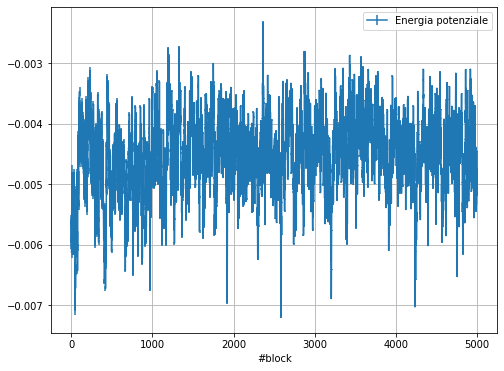

In [73]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

npart=108

N=5000

def AutoC(t, vec):
    appo1=0
    appo2=0
    appo3=0
    appo4=0
    appo5=0
    tmax=0
    tmax=vec.size
    for i in range(tmax-t):
        appo1+=vec[i]*vec[i+t]
        appo2+=vec[i]
        appo3+=vec[i+t]
    for i in range(tmax):
        appo4+=vec[i]*vec[i]
        appo5+=vec[i]
        
    return (appo1/(tmax-t) - appo2*appo3/((tmax-t)*(tmax-t)))/((appo4/tmax)-(appo5/tmax)**2)    



x = np.arange(N) 


Epot, EpotErr= np.loadtxt("data/gas/output_epot.dat", usecols=(1,3), delimiter=' ', unpack='true')


fig=plt.figure(figsize=(8, 6))

plt.errorbar(x,Epot/npart, yerr=EpotErr/npart, marker="", label="Energia potenziale")

plt.xlabel('#block')
plt.ylabel('')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#print(Epot,x)
ACor=[]
print(AutoC(0, Epot))
for i in range(1000):
    
    ACor.append(AutoC(i, Epot))

    
    
    
    
plt.plot(arange(1000),ACor)
plt.show()

1.000000000000006


NameError: name 'Acor' is not defined